# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

*15 May 2023 - "This nb will be a good way for us to exercise our tensor manipulation muscles" - Jeremy*

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

A good way to test an algorithm is by creating synthetic data, where we know how it behaves!!

In [3]:
n_clusters = 6
n_samples = 250
n_samples

250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

First, create 6 random centroids:

In [4]:
trial = torch.rand(n_clusters,2)
trial

tensor([[0.882, 0.915],
        [0.383, 0.959],
        [0.390, 0.601],
        [0.257, 0.794],
        [0.941, 0.133],
        [0.935, 0.594]])

I find it interesting how `torch.rand` creates values between 0 and 1. Why the `(n_clusters,2)`?? Because we ned the points in 2D no?

In [5]:
trial*70

tensor([[61.759, 64.050],
        [26.800, 67.151],
        [27.331, 42.063],
        [17.960, 55.555],
        [65.854,  9.323],
        [65.422, 41.551]])

In [6]:
trial*70 - 35

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

What do the `*70` and `-35` do?? I suppose it the former scales the values out of the `[0,1]` range to the `[0,70]` range, and the latter moves the points leftward - i.e, to the `[-35,35]` range.

In [7]:
centroids = torch.rand(n_clusters, 2)*70-35

Then we need to randomly generate data around these 6 centroids. For this, we've written a function `sample()`:

In [8]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [9]:
def sample(m):
    return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))
# Yet to understand this code!!

`m` denotes the mean values around which random normally distributed values are generated. Here that is a 2-D point. Then `torch.diag(tensor([5.,5.]))` denotes the covariance matrix. 

In [10]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [11]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

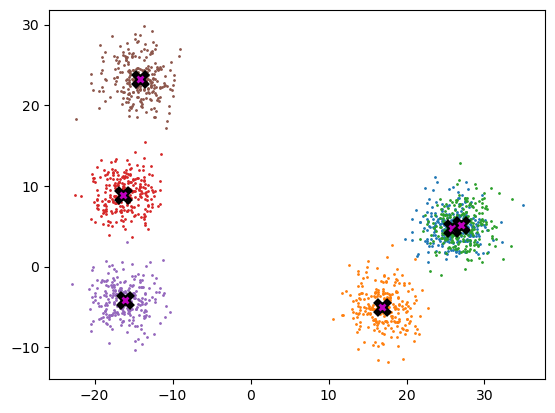

In [12]:
plot_data(centroids, data, n_samples)

Now, how do we build something that takes wheere all these points are, and returns where all the X's are??

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [13]:
midp = data.mean(0)
midp

tensor([3.877, 5.521])

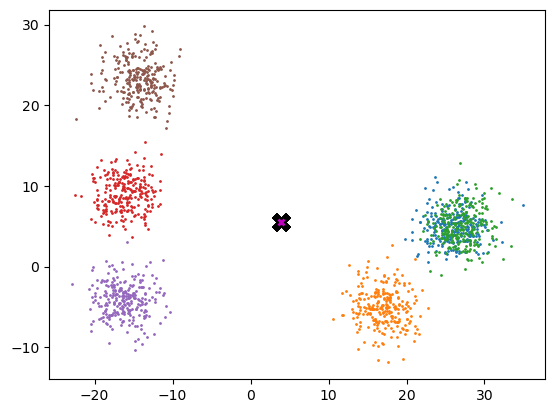

In [14]:
plot_data([midp]*6, data, n_samples)
# Why multiply by 6? It is already a mean value right??

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

*"This is not NORMAL!!"*

Let's define the expression for the gaussian kernel:

In [15]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

It's also useful to have a function to quickly plot and visualise such expressions. `matplotlib` lacks such a function so we'll write on ourselves.

In [16]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

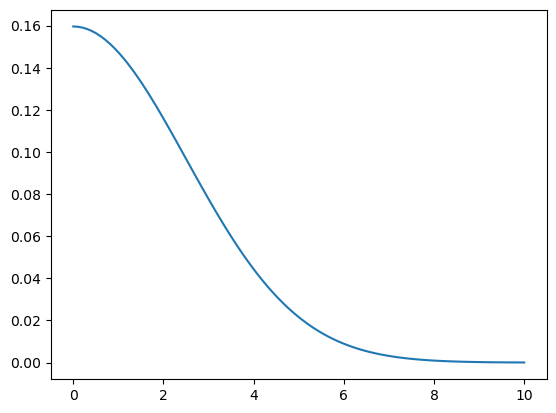

In [17]:
plot_func(partial(gaussian, bw=2.5))

See the function? If very close to the point of interest, you get a high weight. If very far from the point of interest, the weight also becomes low.

Also notice how we managed to plot the gaussian function for a bandwidth of 2.5? We used a special thing from `functools` called `partial`.

In [18]:
partial

functools.partial

*Note: See how we found out where the `partial` comes from? The dumb way to do it is to scroll up all thee way and look at imports. The smart way to do it is to just type it in a cell, run it, and see where it comes from. And if you want more details, run a cell with `partial??`*:

In [19]:
partial?

Init signature: partial(self, /, *args, **kwargs)
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.
File:           ~/mambaforge/lib/python3.9/functools.py
Type:           type
Subclasses:     


In [20]:
partial??

Init signature: partial(self, /, *args, **kwargs)
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.
Source:        
class partial:
    """New function with partial application of the given arguments
    and keywords.
    """

    __slots__ = "func", "args", "keywords", "__dict__", "__weakref__"

    def __new__(cls, func, /, *args, **keywords):
        if not callable(func):
            raise TypeError("the first argument must be callable")

        if hasattr(func, "func"):
            args = func.args + args
            keywords = {**func.keywords, **keywords}
            func = func.func

        self = super(partial, cls).__new__(cls)

        self.func = func
        self.args = args
        self.keywords = keywords
        return self

    def __call__(self, /, *args, **keywords):
        keywords = {**self.keywords, **keywords}
        return self.func(*self.args, *args, **keywords)

    @recursive_repr(

In [21]:
f_try = partial(gaussian, bw=2.5)

In [22]:
f_try(tensor(4.))

tensor(0.044)

`partial` is a super useful function! Without it, plotting the Gaussian kernel would've been more complicated. One alternative is to do this:

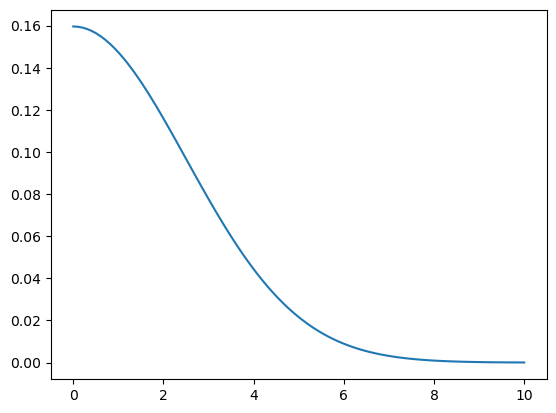

In [23]:
plot_func(lambda x: gaussian(x,bw=2.5))

That works too, but usually `partial` is a bit neater, produces clearer code.

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [24]:
def tri(d, i): return (-d+i).clamp_min(0)/i
#understand this code also. Done

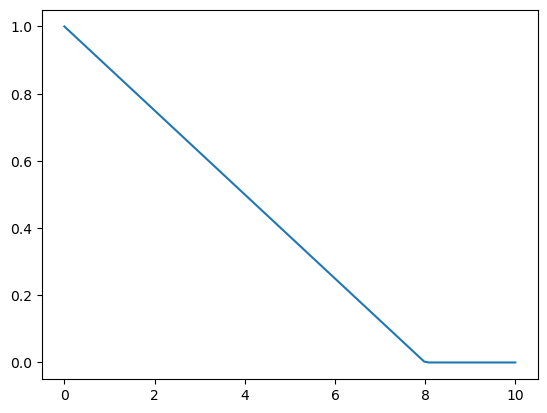

In [25]:
plot_func(partial(tri, i=8))

Notice how the function plotted above is fairly similar to the Gaussian kernel we plan to us for weighting? Just a triangular weeighting function - a linear function clamped at 0 for values `>8`. Could use it too. For now we'll stick to the Gaussian kernel.

Since the algorithm will literally move all the points to their "center of gravity", let's clone the data to maintain the original copy.

In [26]:
X = data.clone()
x = data[0]

`X` is a copy of the original data matrix (of all points), and `x` is the first point:

In [27]:
x

tensor([26.654,  3.205])

In [28]:
x.shape, X.shape, x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

Now we are going to find the distance between `x` and every point in `X`.

In [29]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 1.899, -2.075],
        [ 3.280, -1.740],
        [ 5.977, -1.051],
        [ 1.488, -0.650],
        [-1.001, -0.145],
        [ 2.119, -1.394],
        [ 2.648, -2.275]])

Why use `x[None]`? Because remember the `numpy` rules - the axes have to match up for the subtraction to work. X.shape is `[1500,2]`, and `x[None].shape` is `[1,2]`.

Do we get the same answer with `x-X`?? 

In [30]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [ 1.899, -2.075],
        [ 3.280, -1.740],
        [ 5.977, -1.051],
        [ 1.488, -0.650],
        [-1.001, -0.145],
        [ 2.119, -1.394],
        [ 2.648, -2.275]])

Yep...and that's interesting. It works because, when the matrices involved have shapes if different lengths, a unit axis is added to the missing dimension!

In [31]:
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]
# can rewrite using torch.einsum to get rid of the multiply and sum

tensor([0.000, 2.813, 3.713, 6.068, 1.624, 1.011, 2.537, 3.492])

In [32]:
weight = gaussian(dist, 2.5)
weight

tensor([0.160, 0.085, 0.053,  ..., 0.000, 0.000, 0.000])

The closest point to `x`, i.e, `x` itself, gets a weight of `0.160`. Farther points get a weight small enough that they appear to be zero at 3 decimals - `0.000`

In [33]:
weight.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

Now we want a weighted average - average of the data `X`, weighted by the `weight` tensor.

Now, will `weight*X` work?

In [34]:
weight * X

RuntimeError: The size of tensor a (1500) must match the size of tensor b (2) at non-singleton dimension 1

Nope, it doesn't. The axes have to match (but wait, doesn't a unit axis get created for the missing dimension? Anyway, looks like it doesn't, here. We'll make it manually).

In [35]:
weight[:,None].shape

torch.Size([1500, 1])

In [36]:
weight[:, None]*X

tensor([[4.253, 0.511],
        [2.098, 0.447],
        [1.238, 0.262],
        ...,
        [-0.000, 0.000],
        [-0.000, 0.000],
        [-0.000, 0.000]])

Now let's write a function to put all that together:


In [37]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        weight = gaussian(dist, 2.5)
        # weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

The above function does a *single* step of the weight update. The iterations must continue until the solution converges.

In [38]:
def meanshift(data):
    X = data.clone()
    for it in range(1): one_update(X)
    return X

In [39]:
%time X=meanshift(data)

CPU times: user 525 ms, sys: 0 ns, total: 525 ms
Wall time: 522 ms


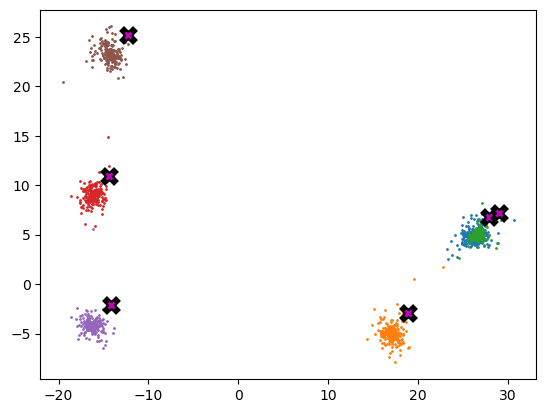

In [40]:
plot_data(centroids+2, X, n_samples)

Interesting to me how such convergence occurs in just ONE update step! What happens with 5?

In [41]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [42]:
%time X=meanshift(data)

CPU times: user 2.22 s, sys: 0 ns, total: 2.22 s
Wall time: 2.22 s


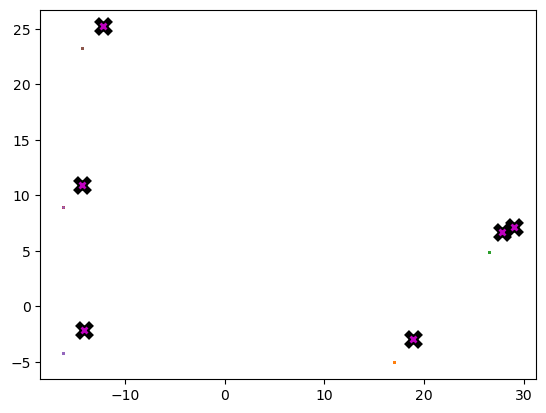

In [43]:
plot_data(centroids+2, X, n_samples)

We've moved the centroids by 2 units just to differentiate them from the formed clusters!! Also you can try the triangular weighting kernel and see how things change.

In [44]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        # weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [45]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [46]:
%time X=meanshift(data)

CPU times: user 1.76 s, sys: 8.92 ms, total: 1.77 s
Wall time: 1.76 s


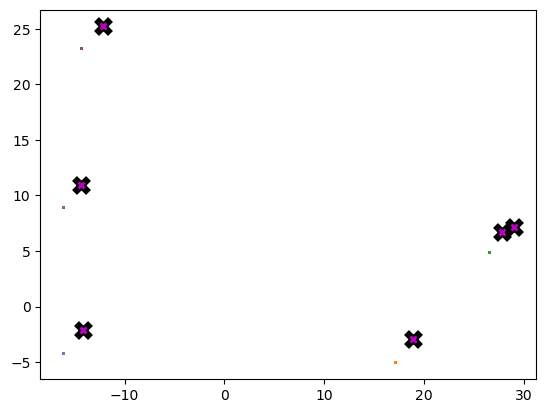

In [47]:
plot_data(centroids+2, X, n_samples)

Not so great? Jeremy seems to get good results in the [video](https://www.youtube.com/watch?v=_xIzPbCgutY)!! *(1:10:20)*

## Animation

Wouldn't it be cool to see things happen one at a time? It isn't just fun - but also important to see things happen one step at a time. So it's important to learn how to do animations!

*I found the documentation unnecessarily complicated.. so here's a simple way to do animations without any trouble - Jeremy*

In [48]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

We'll be using `FuncAnimation` from `matplotlib`.

Look at the `ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)` line. To create an animation, you create a function, and into `FuncAnimation`, pass in the name of the function (`do_one`) and how many times to run it (`frames=5`).

Now, write a function `do_one()` that creates one frame of animation:

In [49]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [50]:
#version of func in video
def do_one(d):
    if not d: return plot_data(centroids+2, X, n_samples, ax=ax)
    one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [51]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

You could now use the same logic and play around with some stable diffusion animations as well. See the `matplotlib.animation` docs for more details:  
*Homework: Create your own animation - could be for some stable diffusion play of yours!*

## GPU batched algorithm

That took one minute to run. Fairly slow, given the size of our data. We can do GPU accleratiom. That's the good news.  
(*To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.*)

The bad news is that the GPU acceleration is a bit tough to do - because of the `for i, x in enumerate(X):` line. Looping through a code 1500 times on GPU using Python is not a good idea, because of the communication overhead involved. Now, we could avoid those loops by using broadcasting. Roll up your sleeves and get to that!

Generally, we do broadcasting using GPU using batches.

In [52]:
bs=5 #create batch size
X = data.clone()
x = X[:bs]
x.shape, X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

This `x` is our mini-batch, the first 5 items. We now need a function to calculate 'distance':

In [59]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [60]:
dist_b(X, x)

tensor([[ 0.000,  2.813,  3.713,  ..., 45.739, 45.099, 45.383],
        [ 2.813,  0.000,  1.421,  ..., 43.035, 42.511, 42.732],
        [ 3.713,  1.421,  0.000,  ..., 42.036, 41.391, 41.670],
        [ 6.068,  4.204,  2.783,  ..., 40.177, 39.276, 39.679],
        [ 1.624,  1.483,  2.097,  ..., 44.132, 43.475, 43.765]])

In [61]:
dist_b(X, x).shape

torch.Size([5, 1500])

Now let's take a deeper look into how that was possible. Can we do `X-x`? No we can't:

In [62]:
X-x

RuntimeError: The size of tensor a (1500) must match the size of tensor b (5) at non-singleton dimension 0

Now what if we add a axis to `X` at the start, an axis to `x` in the middle, and try again?

In [63]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

Now see how the `dist_b()` function makes sense?  
The `2` dimensions match; the `1` dimension is compatible because one is `1500` and the other is `1`; and the `0` dimension also matches.

Now how do we get the weights? The `gaussian` kernel doesn't have to be changed!! 

In [64]:
gaussian??

Signature: gaussian(d, bw)
Docstring: <no docstring>
Source:    def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))
File:      /tmp/ipykernel_255/1178221795.py
Type:      function


Since it's all scalars involved in the function, they get broadcast across. It'll work without any messing around.

In [65]:
weight = gaussian(dist_b(X,x), 2)
weight

tensor([[0.199, 0.074, 0.036,  ..., 0.000, 0.000, 0.000],
        [0.074, 0.199, 0.155,  ..., 0.000, 0.000, 0.000],
        [0.036, 0.155, 0.199,  ..., 0.000, 0.000, 0.000],
        [0.002, 0.022, 0.076,  ..., 0.000, 0.000, 0.000],
        [0.143, 0.152, 0.115,  ..., 0.000, 0.000, 0.000]])

In [66]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

Now we wanna apply, each of these weights to each of these columns.

In [69]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

*Note*: `weight[...,None]` is a nice way to say "Add an axis to the end".

Now, multiply the weights, sum across the 1500 points, and get the 5 new datapoints:

In [72]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [73]:
num

tensor([[1046.464,  159.542],
        [1009.779,  198.138],
        [ 693.898,  135.470],
        [ 172.245,   32.679],
        [1047.922,  177.017]])

See how `num = (weight[...,None]*X[None]).sum(1)` has a product and a sum? So we can use `einsum`!!

In [74]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[1046.463,  159.542],
        [1009.779,  198.138],
        [ 693.897,  135.470],
        [ 172.245,   32.679],
        [1047.922,  177.017]])

Well, that was the same formula we used for matrix multiplication, didn't we? Guess we just reinvented matrix multiplication at the `(weight[...,None]*X[None]).sum(1)` step!

In [75]:
weight@X

tensor([[1046.463,  159.542],
        [1009.779,  198.138],
        [ 693.897,  135.470],
        [ 172.245,   32.679],
        [1047.922,  177.017]])

Now, figure out the divisor (sum of weights):

In [76]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [77]:
num/div

tensor([[26.525,  4.044],
        [25.491,  5.002],
        [24.738,  4.830],
        [23.174,  4.397],
        [25.702,  4.342]])

Now that we have all the steps ready, put them all together to write a function!  
*(don't try to write a function like this from scratch. Play with the components and put them together):*

In [78]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

The `slice` you see here is what Python uses when you use `:` in tensors. Super useful.

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

Pop the data onto the GPU:

In [80]:
data = data.cuda()

Run `meanshift()`, and pull the data back to the cpu.

In [100]:
X = meanshift(data).cpu()

In [102]:
%timeit -n 5 _=meanshift(data, 1).cpu()

1.67 s ± 38.7 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [103]:
%timeit -n 5 _=meanshift(data, 500).cpu()

The slowest run took 4.26 times longer than the fastest. This could mean that an intermediate result is being cached.
15.7 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


See the difference between those two runs? Batch size matters!!

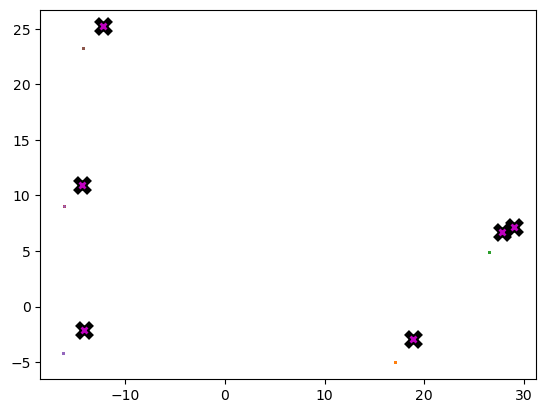

In [83]:
plot_data(centroids+2, X, n_samples)

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D